### The scenarios in this notebook are tweaked a bit from the original hackathon version to provide some working examples of how the PyCIEMSS `optimize` interface may be used.

# July 2024 Scenario 2* - Limiting Hospitalizations
*from ASKEM 6-month Hackathon Scenarios

### Scenario Background 
You are a disease modeler supporting the Los Angeles County Department of Public Health, at the beginning of the original Omicron wave. The LA County Board of Supervisors is concerned about what the next few months will look like, and what level of intervention will be required to manage what is shaping up to be a large winter Covid-19 wave. Vaccines were broadly available during this time period and vaccination should be accounted for in the modeling.

### Scenario Setting/Situation
Time = December 28th, 2021 (right around upswing of Omicron wave)

Location = LA County

### Load dependencies

In [1]:
import os
import json
import sympy
import torch
import numpy as np
import pandas as pd
from typing import Dict, List, Callable

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

# Select data and model, set parameters for sampling

Data date range: October 28, 2021 - December 28, 2021

Data source: Cumulative case and death data from New York Times [COVID-19 Data Github](https://github.com/nytimes/covid-19-data)

In [2]:
data = "LA_county_covid_data.csv"
model = "SEIRHD_vacc_petrinet.json"

start_time = 0.0
end_time = 151.0 # simulate from 10/28/2021 to 03/28/2022
logging_step_size = 1.0
num_samples = 100

# Calibrate and forecast

### Set up and perform calibration

In [3]:
data_mapping = {"cases": "cumulative_cases", "deaths": "deceased"} # data is mapped to observables

num_iterations = 500
calibrated_results = pyciemss.calibrate(
    model, 
    data, 
    data_mapping=data_mapping, 
    num_iterations=num_iterations
)
parameter_estimates = calibrated_results["inferred_parameters"]
parameter_estimates()

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 61 rows of data. The first column, Timestamp, begins at 0 and ends at 61. The subsequent columns are named: cases, deaths


{'persistent_NPI_mult': tensor(0.9995, grad_fn=<ExpandBackward0>),
 'persistent_beta': tensor(0.1162, grad_fn=<ExpandBackward0>),
 'persistent_r_Sv': tensor(9999.0693, grad_fn=<ExpandBackward0>),
 'persistent_r_EI': tensor(0.2191, grad_fn=<ExpandBackward0>),
 'persistent_r_IH_u': tensor(0.0043, grad_fn=<ExpandBackward0>),
 'persistent_r_IH_v': tensor(0.0015, grad_fn=<ExpandBackward0>),
 'persistent_r_HR': tensor(0.1966, grad_fn=<ExpandBackward0>),
 'persistent_r_HD': tensor(0.0109, grad_fn=<ExpandBackward0>),
 'persistent_r_IR_u': tensor(0.1409, grad_fn=<ExpandBackward0>),
 'persistent_r_IR_v': tensor(0.1931, grad_fn=<ExpandBackward0>)}

### Simulate a 3-month forecast and plot results with data (Scenario 2 - Part I)

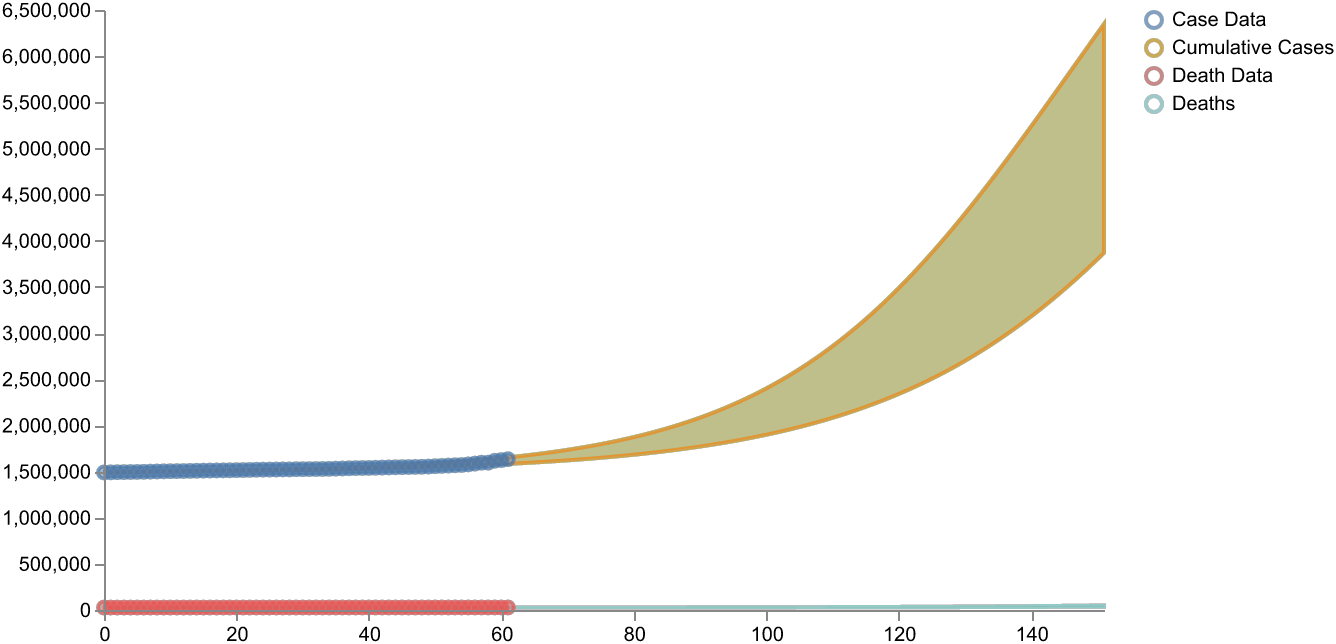

In [4]:
calibrated_sample_results = pyciemss.sample(
    model, 
    end_time, 
    logging_step_size, 
    num_samples,             
    start_time=start_time, 
    inferred_parameters=parameter_estimates
)
# display(calibrated_sample_results["data"].head())

# Plot the result
nice_labels = {
        "cumulative_cases_observable_state": "Cumulative Cases",
        "deceased_observable_state": "Deaths", 
        }
nice_data_names = {
        "cases": "Case Data",
        "deaths": "Death Data"
        }
data_df = pd.read_csv(data)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(calibrated_sample_results["data"]), 
    keep=["cumulative_cases_observable_state", "deceased_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Plot results for hospitalizations (Scenario 2 - Part II)

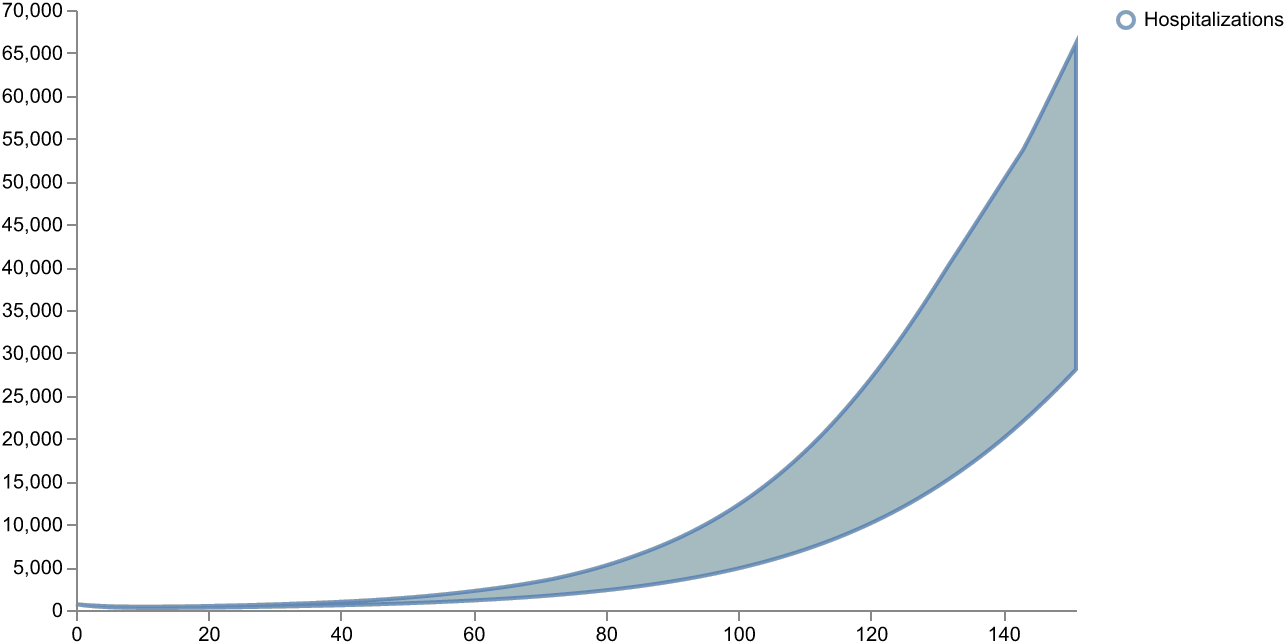

In [5]:
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        }

schema = plots.trajectories(
    calibrated_sample_results["data"], 
    keep="hospitalized_observable_state",
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Find optimal start time for an intervention with 75% reduction in transmission to keep hospitalizations below 20,000 (Adjusted Scenario 2 - Part III)

### Set up optimization and quantity of interest

In [6]:
num_samples_ouu = 100 # controls accuracy of risk estimation in each optimization iteration
maxiter = 3    # maximum number of restarts of local convex optimizer leading to maxiter+1 local optimizations
maxfeval = 30  # maximum number of function evaluations in each instance of local convex optimization

# Define QOI as maximum value over entire simulation
def obs_max_qoi(samples: Dict[str, torch.Tensor], contexts: List) -> np.ndarray:
    """
    Return maximum value over simulated time.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.max(dataQoI, axis=1)

### Optimize intervention start time

Find the latest time (after 12/28/2021) an intervention which reduces transmission by 75% can be applied to keep hospitalizations below 20,000

In [7]:
# Define optimization problem setup
observed_params = ["H_state"]
intervened_params = ["NPI_mult"]
initial_guess_interventions = 61.0
bounds_interventions = [[61.0], [end_time]] # bounds within 12/28/2021 and end_time
intervention_value = torch.tensor([0.25])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 20000.0
qoi = lambda y: obs_max_qoi(y, observed_params)
objfun = lambda x: -x

# Run optimize interface
optimization_result = pyciemss.optimize(
    model,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
)

print(f'Optimal policy:', optimization_result["policy"])
print(optimization_result)
print("Intervention: ", static_parameter_interventions(optimization_result["policy"]))

 41%|███████████████████▏                           | 49/120 [01:46<02:33,  2.17s/it]

Optimal policy: tensor([86.9452], dtype=torch.float64)
{'policy': tensor([86.9452], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -86.94519816961017
                          x: [ 8.695e+01]
                        nit: 3
      minimization_failures: 0
                       nfev: 49
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: -86.94519816961017
                                   x: [ 8.695e+01]
                                nfev: 12
                               maxcv: 0.0}
Intervention:  {86.9452: {'NPI_mult': tensor(0.2500)}}


In [8]:
static_parameter_interventions(optimization_result["policy"])

{86.9452: {'NPI_mult': tensor(0.2500)}}

### Sample with intervention at optimal time

Risk associated with QoI: [20952.788671874998]


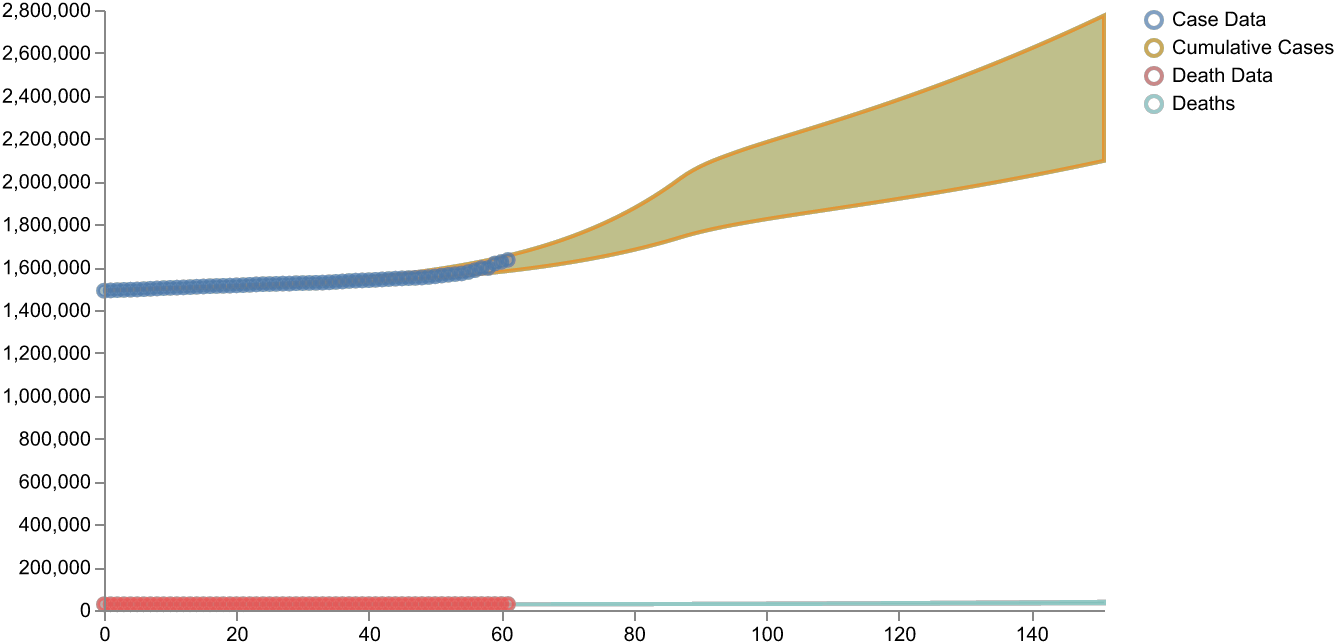

In [9]:
opt_intervention_result = pyciemss.sample(
    model,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions=static_parameter_interventions(optimization_result["policy"]),
)

# Check risk estimate used in constraints
print("Risk associated with QoI:", opt_intervention_result["risk"][observed_params[0]]["risk"])

# Plot the result
nice_labels = {
        "cumulative_cases_observable_state": "Cumulative Cases",
        "deceased_observable_state": "Deaths", 
        }
nice_data_names = {
        "cases": "Case Data",
        "deaths": "Death Data"
        }
data_df = pd.read_csv(data)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(opt_intervention_result["data"]), 
    keep=["cumulative_cases_observable_state", "deceased_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Plot hospitalizations with optimal intervention applied

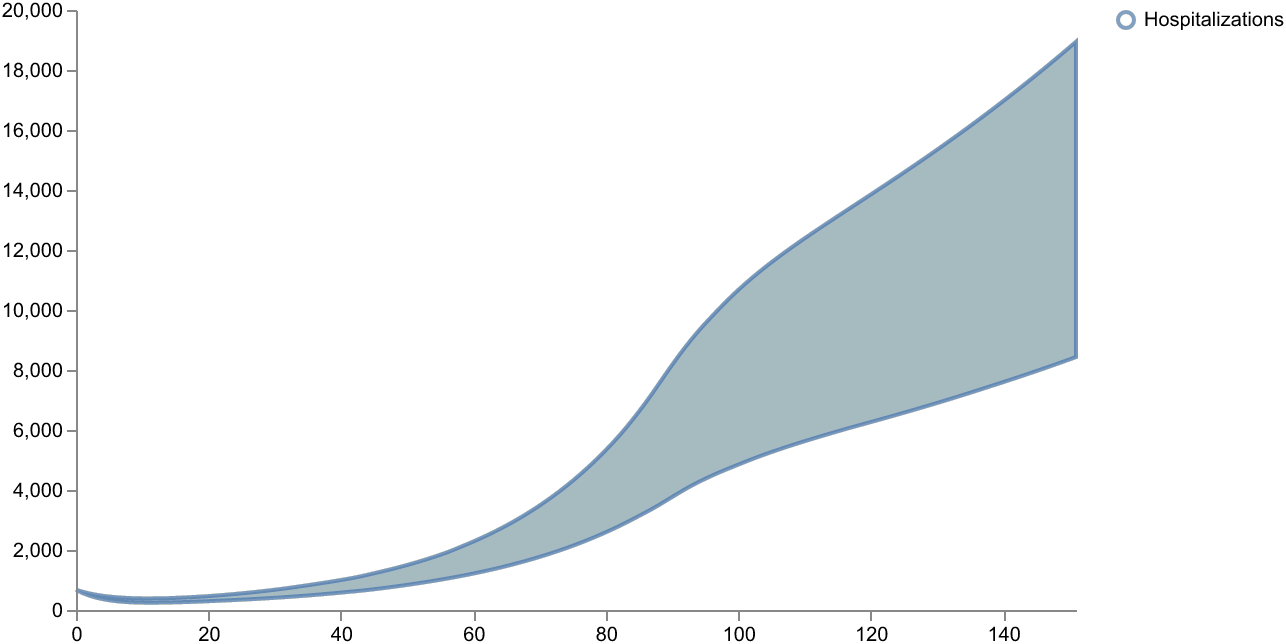

In [10]:
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        }

schema = plots.trajectories(
    opt_intervention_result["data"], 
    keep="hospitalized_observable_state",
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Aggressive vaccination campaign to keep hospitalizations below 20,000 (Adjusted Scenario 2 - Part V)

How many people should be vaccinated per day to keep hospitalizations below 20,000?

Note that the total number of people you would need to vaccinate per day is `2 * r_Sv`. The parameter `r_Sv` represents the number of individuals vaccinated per day from both the unvaccinated population `S_u` and the recovered population `R`.

In [11]:
# Define optimization problem setup
observed_params = ["H_state"]
intervention_time = [torch.tensor(60.0)]
intervened_params = ["r_Sv"]
current_param_value = 10000
initial_guess_interventions = 20000
bounds_interventions = [[10000], [30000]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor(x)],
    start_time = intervention_time,
)

risk_bound = 20000.0
qoi = lambda y: obs_max_qoi(y, observed_params)
objfun = lambda x: np.abs(current_param_value - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
)

print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

  5%|██▍                                             | 6/120 [00:14<04:14,  2.23s/it]/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:108: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciem

Optimal policy: tensor([30003.9063], dtype=torch.float64)
{'policy': tensor([30003.9063], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 120023.4375
                          x: [ 3.000e+04]
                        nit: 3
      minimization_failures: 4
                       nfev: 120
 lowest_optimization_result: message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
                             success: False
                              status: 4
                                 fun: 120023.4375
                                   x: [ 3.000e+04]
                                nfev: 30
                               maxcv: 20000.0}



/Users/altu809/Projects/pyciemss/pyciemss/interfaces.py:959: UserWarning: Optimal intervention policy is out of bounds. Try (i) expanding the bounds_interventions and/or(ii) different initial_guess_interventions.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/interfaces.py:964: UserWarning: Optimal intervention policy does not satisfy constraints.Check if the risk_bounds value is appropriate for given problem.Otherwise, try (i) different initial_guess_interventions, (ii) increasing maxiter/maxfeval,and/or (iii) increase n_samples_ouu to improve accuracy of Monte Carlo risk estimation. 
  warnings.warn(


In [12]:
static_parameter_interventions(opt_result1["policy"])

{60.0: {'r_Sv': tensor(30003.9062)}}

### Sample with intervention at optimal time

Risk associated with QoI: [79377.071875]


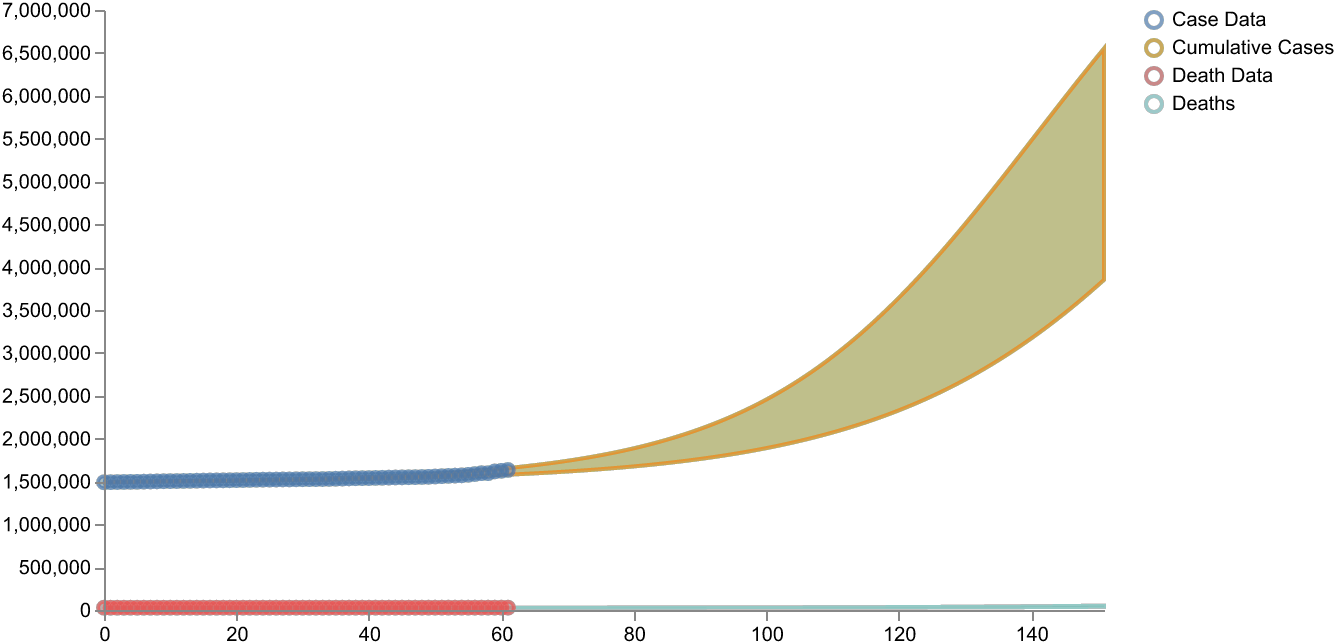

In [13]:
opt_intervention_result = pyciemss.sample(
    model,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions=static_parameter_interventions(optimization_result["policy"]),
)

# Check risk estimate used in constraints
print("Risk associated with QoI:", opt_intervention_result["risk"][observed_params[0]]["risk"])

# Plot the result
nice_labels = {
        "cumulative_cases_observable_state": "Cumulative Cases",
        "deceased_observable_state": "Deaths", 
        }
nice_data_names = {
        "cases": "Case Data",
        "deaths": "Death Data"
        }
data_df = pd.read_csv(data)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(opt_intervention_result["data"]), 
    keep=["cumulative_cases_observable_state", "deceased_observable_state"], 
    relabel=nice_labels,
    points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

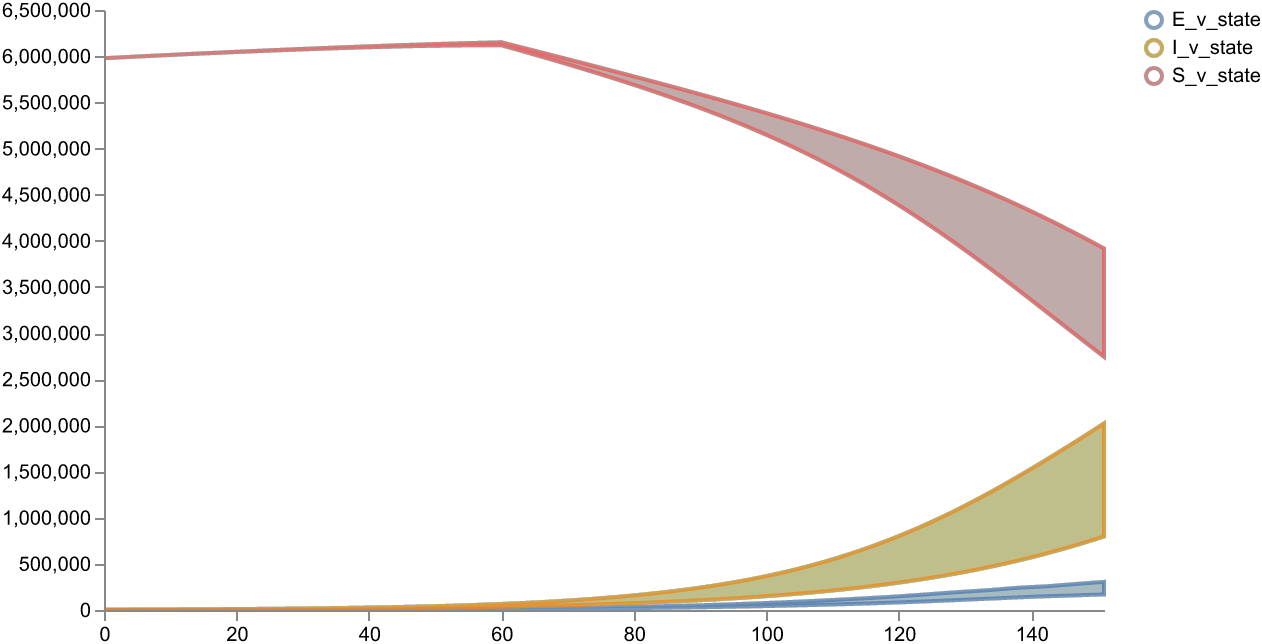

In [16]:
# Plot the result

data_df = pd.read_csv(data)
data_df.rename(columns=nice_data_names, inplace=True)
schema = plots.trajectories(
    pd.DataFrame(opt_intervention_result["data"]), 
    keep=".*v_state"
)

plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Plot hospitalizations with optimal intervention applied

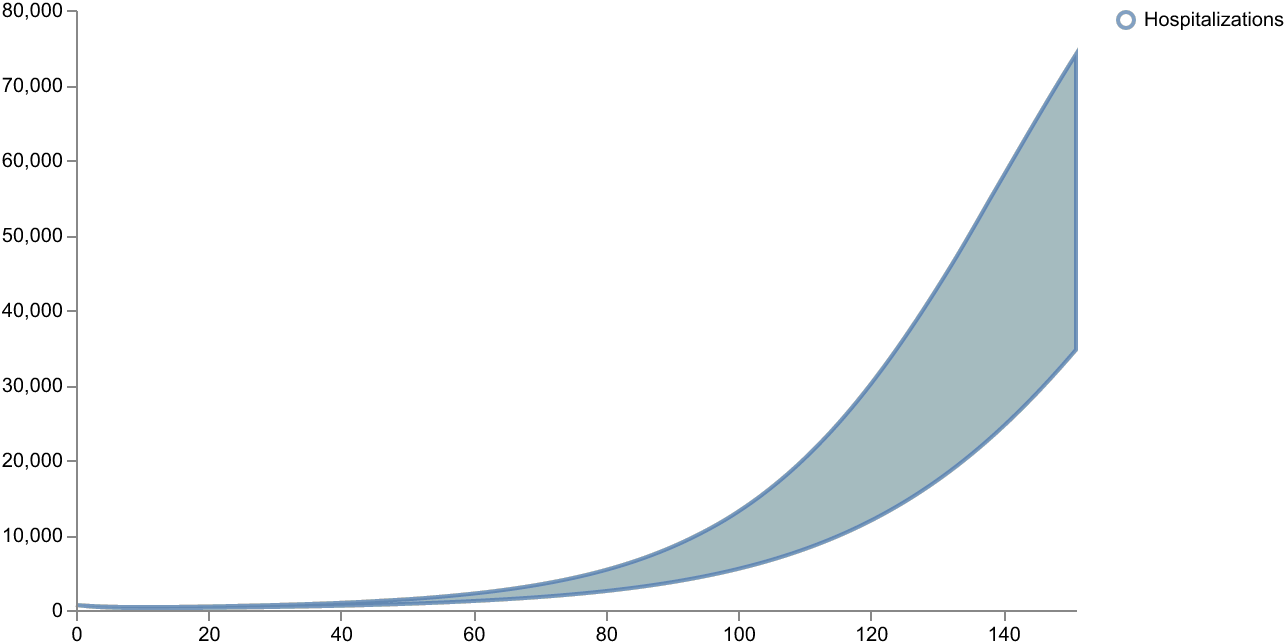

In [15]:
nice_labels = {
        "hospitalized_observable_state": "Hospitalizations", 
        }

schema = plots.trajectories(
    opt_intervention_result["data"], 
    keep="hospitalized_observable_state",
    relabel=nice_labels
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)